# Predict Survival on Titanic  

In this notebook, I will fit and try to predict survival in the Titanic using the Titanic dataset which is available on [kaggle](https://www.kaggle.com/c/titanic/data).

In [62]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

## Load dataset

In [3]:
def load_dataset(path = 'titanic'):
    dataset_path = os.path.join(path, 'train.csv')
    return pd.read_csv(dataset_path)

In [4]:
df = load_dataset()

*Since test.csv does not have labels column on it, I won't be using it. gender_submission.csv is an example with dummy values, so it will be ignored as well.*

## Data Structure

In [6]:
# Print first few rows of the dataset
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Description of data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Some columns like *Age*, *Cabin*, *Embarked* have some missing data. Also, notice that there are 5 columns that carry string data.

In [8]:
# Description of Numerical data
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


I'll check whether string columns contain categorical values. *Name* obviously is not categorical and *sex* is. They would be ignored here. I'll use value counts to check each column.

In [12]:
df['Ticket'].value_counts()

347082        7
CA. 2343      7
1601          7
3101295       6
347088        6
             ..
2693          1
28425         1
2667          1
350047        1
A/5. 10482    1
Name: Ticket, Length: 681, dtype: int64

In [13]:
df['Cabin'].value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
F2             3
F33            3
              ..
A24            1
D46            1
E63            1
C87            1
D37            1
Name: Cabin, Length: 147, dtype: int64

In [14]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

*Embarked* is a categorical column. *Ticket* and *Cabin* are not much categorical. Since *Cabin* has a lot of missing values, I will remove that from the dataset later on.

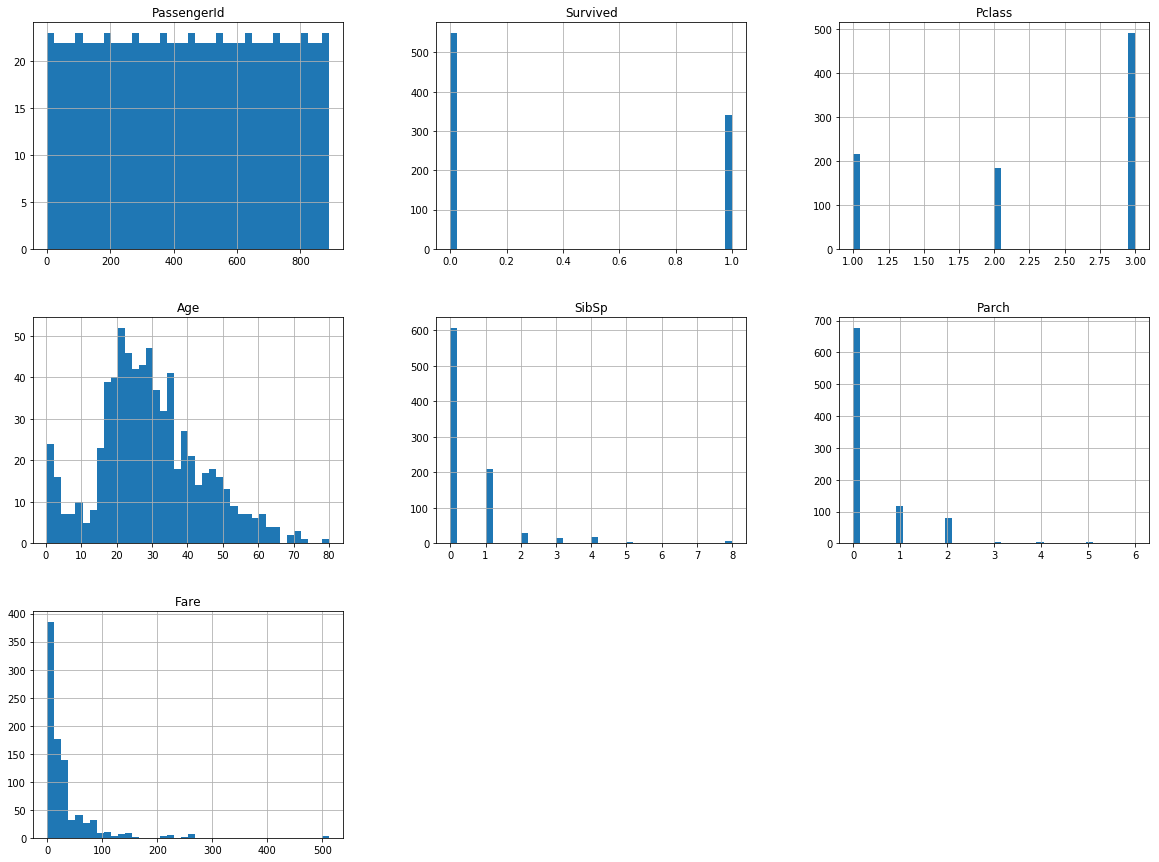

In [30]:
# A histogram to understand numerical attributes better
df.hist(bins = 40, figsize = (20, 15))
plt.show()

From the histograms above, it is clear that all of these attributes are on different scales and *Age* and *Fare* extend farther to the right of the median.

In [22]:
# Looking for correlations
correlations = df.corr()
correlations['Survived'].sort_values(ascending = False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

Looks like *Fare* has the most positive influence on *Survived* and *Pclass* has the most negative influence. Below is the scatter matrix to check correlations in a graphical way.

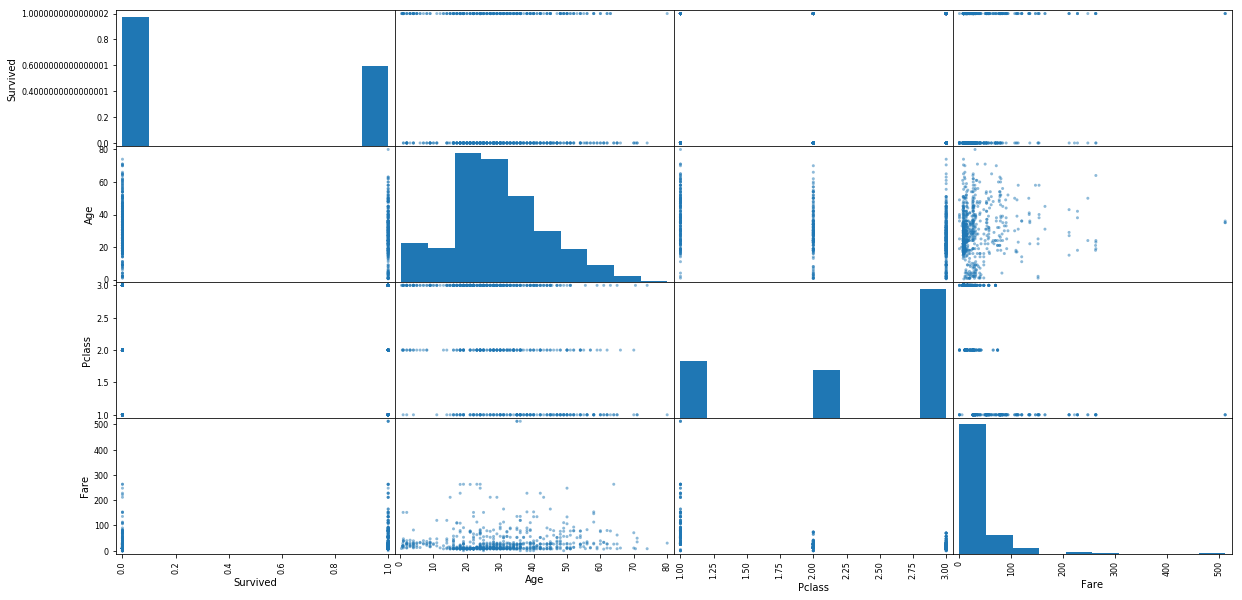

In [29]:
scatter_attributes = ['Survived', 'Age', 'Pclass', 'Fare']
pd.plotting.scatter_matrix(df[scatter_attributes], figsize = (20,10))
plt.show()

## Create train, test datasets  

I will create train and test datasets in a 80-20 rate. First, I will separate attributes and labels.

In [23]:
def create_train_test(df):
    y = df['Survived']
    X = df.drop('Survived', axis = 1)
    return train_test_split(X, y, test_size = 0.2)

In [24]:
X_train, X_test, y_train, y_test = create_train_test(df)

In [25]:
# Dimensions of each dataframes
print("Dimensions of X_train: {}".format(X_train.shape))
print("Dimensions of y_train: {}".format(y_train.shape))
print("Dimensions of X_test: {}".format(X_test.shape))
print("Dimensions of y_test: {}".format(y_test.shape))

Dimensions of X_train: (712, 11)
Dimensions of y_train: (712,)
Dimensions of X_test: (179, 11)
Dimensions of y_test: (179,)


## Preprocessing

In [49]:
# Select columns for specific transformations and processing
drop_cols = ['Cabin', 'Name', 'PassengerId', 'Ticket']
num_cols = ['Fare', 'Age']
cat_cols = ['Sex', 'Embarked']

In [50]:
# Imports for bulding data transformation pipelines
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [51]:
# Pipeline to transform numerical attributes. This will replace median of each column with missing values and standardize attributes
num_transfs = [('impute', SimpleImputer(strategy = 'median')), ('std_scaler', StandardScaler())]
num_pipeline = Pipeline(num_transfs)

In [52]:
# Pipeline to transform categorical attributes. This will replace most frequent of each column with missing values and assign numbers for each categories.
cat_transfs = [('impute', SimpleImputer(strategy = 'most_frequent')), ('encoder', OrdinalEncoder())]
cat_pipeline = Pipeline(cat_transfs)

In [53]:
# The complete pipeline to transform entire dataframes
all_transfs = [('numeric', num_pipeline, num_cols), ('categorical', cat_pipeline, cat_cols), ('drops', 'drop', drop_cols)]
full_pipeline = ColumnTransformer(all_transfs, remainder = 'passthrough')

In [54]:
# Transform train dataset
X_train_transformed = full_pipeline.fit_transform(X_train)

## Training models and evaluating

First, I will try with a SVM Classifier.

In [55]:
from sklearn.svm import SVC

clf_rbf = SVC(kernel = 'rbf', gamma = 'scale')

In [56]:
clf_rbf.fit(X_train_transformed, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [57]:
# Transforming test dataset

X_test_transformed = full_pipeline.transform(X_test)

In [59]:
# Predict test set
svc_preds = clf_rbf.predict(X_test_transformed)

In [64]:
# Evaluating the model
from sklearn.metrics import mean_squared_error
def get_rmse(y_test, preds):
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    return rmse

In [65]:
svc_rmse = get_rmse(y_test, svc_preds)
svc_rmse

0.3955054753168236

Root mean squared error of the RBF kernel version of the SVC is 0.4.

Then I will try a Random Forest Classifier.

In [66]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()

In [68]:
# Fit the model
rf_preds = clf_rf.fit(X_train_transformed, y_train)

/home/batman/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [69]:
# Predict test set
rf_preds = clf_rf.predict(X_test_transformed)

In [70]:
rf_rmse = get_rmse(y_test, rf_preds)
rf_rmse

0.454647017602145

Root mean squared error of the Random Forest model is 4.5. It's worse than the SVC model.

Finally, I will try a Gaussian Naive Bayes model.

In [71]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()

In [72]:
# Fit the model
nb_clf.fit(X_train_transformed, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [73]:
# Predict test set
nb_preds = nb_clf.predict(X_test_transformed)

In [74]:
nb_rmse = get_rmse(y_test, nb_preds)
nb_rmse

0.4901259671626783

This is the worst of all models, rmse-wise.